In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
from numba import njit

<h3>Forward Problem - Generating Training Data</h3>

In [2]:
@njit
def toeplitz(r, c):
    c = np.asarray(c).ravel()
    r = np.asarray(r).ravel()
    # Form a 1-D array containing a reversed c followed by r[1:]
    # that can be strided to give us toeplitz matrix.
    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

In [3]:
# set radius of spatial domain
bigL = 16

# vector of real space grid points used for plotting
nx = 1000
xvec = np.linspace(-bigL, bigL, nx)

# set number of Fourier basis
nfb = 128
# construct matrix to convert Fourier basis coefficients
# into real space values
nvec = np.arange(-nfb, nfb+1) # nvec=-nfb,...,0,...,nfb
fbmat = (1 / np.sqrt(2 * bigL)) * np.exp(1j * np.pi * np.outer(nvec, xvec) / bigL)

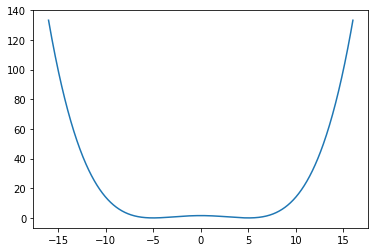

In [4]:
# define potential for generating training data

def v(x, choice=1):
    if choice == 0:
        # dimensionless quantum harmonic oscillator potential
        return 0.5 * x**2
    elif choice == 1:
        # rescaled symmetric double well potential
        return 0.0025*(x**2 - 25)**2
    elif choice == 2:
        # scaled asymmetric double well potential
        return 0.0003*((x-3)**4 + 10*(x-5)**3)
    elif choice == 3:
        # soft coulomb potential
        return -1 / np.sqrt(x**2 + 0.25)
    else:
        print('Potential Function: Choice not recognised.')
        return None

# compute true potential
vtrue = v(xvec)

# plot true potential
plt.plot(xvec, vtrue)
plt.show()

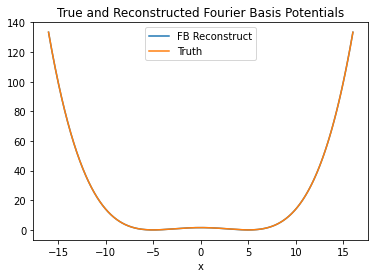

In [5]:
# this code transforms the true potential to the
# Fourier basis

# the integer '100' can be adjusted to improve resolution
# if we set fsample = 2*nfb, then we are sampling at the
# Nyquist frequency
fbsample = 100 * 2 * nfb
xfbvec = np.linspace(-bigL, bigL, fbsample+2)
vfbvec = np.fft.rfft(v(xfbvec), norm='forward')
vfbvecrec = np.fft.irfft(vfbvec, norm='forward')

# plot potentials
plt.plot(xfbvec, vfbvecrec, label='FB Reconstruct')
plt.plot(xvec, vtrue, label='Truth')
plt.title('True and Reconstructed Fourier Basis Potentials')
plt.xlabel('x')
plt.legend()
plt.show()

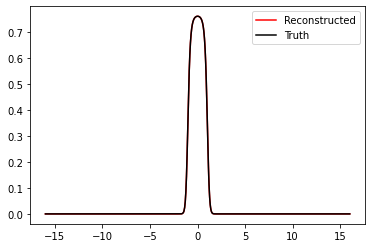

Relative norm difference: 5.020497310825217e-05


In [6]:
# this code transforms the initial state psi0 to the Fourier basis
# the resulting vector is called inita

def gen_inita():
    def psi0(x, choice=0):
        if choice == 0:
            # rounded box function
            return 1.0 + np.tanh((1 - x**2)/0.5)
        elif choice == 1:
            # triangular pulse
            return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])
        elif choice == 2:
            # parabolic pulse
            return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])
        elif choice == 3:
            # hyperbolic secant squared
            return (np.cosh(x))**(-2)
        elif choice == 4:
            # Laplace
            return np.exp(-np.abs(x))
        else:
            print('Initial State Function: Did not recognise your choice.')
            return None

    # normalize psi0
    norm = np.sqrt(si.quad(lambda x: np.abs(psi0(x))**2, a=-bigL, b=bigL)[0])
    def normpsi0(x):
        return psi0(x)/norm

    # transform psi0 to Fourier basis using quadrature method
    # i.e., compute the Fourier coefficients by integration
    vraw = np.zeros(nfb+1, dtype=np.complex128)
    for thisn in range(nfb+1):
        def integ(x):
            return np.exp(-1j * np.pi * thisn * x / bigL) * normpsi0(x)
            # return (1 / np.sqrt(2 * bigL)) * np.exp(-1j * np.pi * thisn * x / bigL) * normpsi0(x)
        def rinteg(x):
            return np.real(integ(x))
        def iinteg(x):
            return np.imag(integ(x))
        vraw[thisn] = (1 / np.sqrt(2 * bigL)) * (si.quad(rinteg, a=-bigL, b=bigL)[0] + 1j * si.quad(iinteg, a=-bigL, b=bigL)[0])
        # vraw[thisn] = si.quad(rinteg, a=-bigL, b=bigL)[0] + 1j * si.quad(iinteg, a=-bigL, b=bigL)[0]

    return np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw]), normpsi0(xvec)

inita, normpsi0true = gen_inita()

# check if the reconstructed psi0 is "close enough" to the true psi0
psi0recon = inita @ fbmat
plt.plot(xvec, psi0recon.real, color='red', marker='', linestyle='-', label="Reconstructed")
plt.plot(xvec, normpsi0true.real, color='black', marker='', linestyle='-', label="Truth")
plt.legend()
plt.show()

# quantify difference between reconstructed psi0 and true psi0
print('Relative norm difference:', nl.norm(normpsi0true - psi0recon) / nl.norm(normpsi0true))

In [7]:
# function for computing the real space grid points, xg,
# for the Gaussian basis functions give some J and L
def xgvecfn(J, L):
    # make vector of x points for Gaussian centers
    # with spacing h
    h = L/J
    xg = np.arange(-J, J+1) * h
    return xg


# function for generating Gaussian basis matrix (gmat)
def gbmatfn(x, xg, alpha):
    # make arrays that can be used in vectorized evaluations
    # row values are x1 and column values are x2
    xv, xgv = np.meshgrid(x, xg, sparse=True, indexing='ij')

    # vectorized version of Gaussian basis function
    # Gaussian centered at grid point j*h with shape parameter alpha
    # z_{ij} = x_i - j*h
    def gbm(z, alpha):
        return np.exp(-alpha * z**2)

    # make Gaussian basis matrix
    # We want [gbmat @ cfs](x_i) = vtrue(x_i), so each row
    # in gbmat is an x_i point and each column is a j*h
    # point. Given N x_i points and J j values, gbmat
    # is an NxJ matrix
    return gbm(xv - xgv, alpha)


# function for computing the Gaussian basis coefficients
# given a vector of the function evaluated on the real
# space grid of the Gaussian basis
def gbcfs(fxg, xg, alpha):
    # make Gaussian basis matrix
    gbmat = gbmatfn(xg, xg, alpha)

    # solve gbmat @ gbcfs = fxjtrue
    # to compute Gaussian basis coefficients
    # gbmat must be a square matrix
    cfs = sl.solve(gbmat, fxg, assume_a='sym')

    return cfs

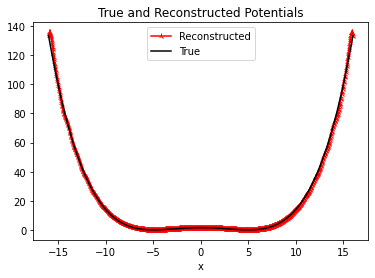

In [8]:
bigJ = 16

# alpha determines the amount of overlap of our basis
# it shouldn't be too much or too little, it should also
# scale with the number of basis used.
# values of alpha to try: 4.0, 5.0, 6.0, 7.0
myalpha = 2.0

# this code computes the Gaussian basis coefficients
# for the true potential

xgvec = xgvecfn(bigJ, bigL)

cfstru = gbcfs(v(xgvec), xgvec, myalpha)

# this forms the matrix used for converting Gaussian basis
# coefficients to real space (for plotting)
# xvec is the rows of the matrix, xgvec is the column
gmatplot = gbmatfn(xvec, xgvec, myalpha)

# reconstruct the potential from the Gaussian basis coefficients
vxtrurec = gmatplot @ cfstru

# plot real potential vs. reconstructed potential
plt.plot(xvec, vxtrurec, '2-r', label='Reconstructed')
plt.plot(xvec, vtrue, 'k', label='True')
plt.title('True and Reconstructed Potentials')
plt.xlabel('x')
plt.legend()
plt.show()

In [9]:
# set number of elements for toeplitz representation
# in the Fourier basis
ntoep = 2 * nfb + 1

# constant needed for making the potential matrix and its
# gradient.
# this constant only depends on the number of Fourier
# basis functions and L
# kspace_n = 2 \pi n / (b - a) --> (b - a) = L + L
# thus kspace_n = \pi n / L
# n = {-2ng, ..., 2ng}, but we only need to look at
# n = {0, ..., 2ng} because the neg values are the
# conjugate of the postive values
ksvec = np.pi * np.arange(0, ntoep) / bigL

In [10]:
# this code computes the potential matrix in the
# Fourier basis given a set of Gaussian basis coefficients.
# this computes the potential matrix directly by FT the Gaussian
# basis model. It should be a linear combo of FT Gaussians.

def gvmatgrdvmat(xg, L, alpha):
    # set number of Gaussian basis given some J
    ng = len(xg)

    # constants needed for making the potential matrix and its
    # gradient.
    cnstexpvec = np.exp(-ksvec ** 2 / (4 * alpha))
    cnsttrmmkgvmat = (1 / (2 * L)) * np.sqrt(np.pi / alpha) * cnstexpvec

    ksmes, xgmes = np.meshgrid(ksvec, xg, sparse=True, indexing='ij')
    # this should be a matrix with dimensions (ng x numkspace)
    # xg points make the rows and ks points make the columns
    cnstgfbmat = np.exp(-1j * ksmes * xgmes)


    @njit
    # cfs is the vector of Gaussian basis coefficients
    def mkgvmatfn(cfs):
        cfsexpvec = cnstgfbmat @ cfs.astype(np.complex128)
        column = cnsttrmmkgvmat * cfsexpvec
        row = column.conj()
        return toeplitz(r=row, c=column)


    # this code computes the gradient of the potential matrix
    # in the Fourier basis given a set of Gaussian basis
    # coefficients
    # this is the gradient of the potential matrix WRT
    # the Gaussian coefficients, so it should be a
    # tensor of dimensions (ng x nx x nfb) (i.e. the
    # potential matrix WRT each of the Gaussian basis functions
    gradgvmatrtn = np.zeros((ng, ntoep, ntoep), dtype=np.complex128)
    for i in range(ng):
        thiscfs = np.zeros(ng)
        thiscfs[i] = 1
        gradgvmatrtn[i] = mkgvmatfn(thiscfs)

    return mkgvmatfn, gradgvmatrtn

In [11]:
mkgvmat, gradgvmat = gvmatgrdvmat(xgvec, bigL, myalpha)
print(mkgvmat(cfstru).shape)
print(gradgvmat.shape)

(257, 257)
(33, 257, 257)


---
**Functions for Propagating System Given Some amat**

In [12]:
# forward propagation
# this code constructions the Hamiltonian matrix
# and performs an eigendecomposition to create 
# the forward propagation matrix, it then propagates
# the given inita nt times steps foward in time

# set the time step size for propagating
dt = 0.01

# set the number of time steps to propagate
nt = 200

# construct kinetic matrix
# this is constant for a given system
kmat = np.diag(np.arange(-nfb,nfb+1) ** 2 * np.pi ** 2 / (2 * bigL ** 2))


# define function for propagating system
# nt sets the number of time steps to propagate
# the system in time
@njit
def propa(gbcfspropa, initapropa, ntpropa, mkgvmatfn):
    # form the potential matrix (in the Fourier basis)
    # using a set of Gaussian basis coefficients
    vmatpropa = mkgvmatfn(gbcfspropa)

    # construct Hamiltonian matrix (in Fourier basis)
    hmatpropa = kmat + vmatpropa

    # eigen-decomposition Hamiltonian matrix
    spcpropa, sttspropa = np.linalg.eigh(hmatpropa)
    
    # form a vector propagator matrix
    propamat = sttspropa @ np.diag( np.exp(-1j * spcpropa * dt) ) @ sttspropa.T.conj()
    
    # propagate the a vector, i.e., solve the *forward* problem
    amat = np.zeros((ntpropa + 1, 2 * nfb + 1), dtype=np.complex128)
    amat[0, :] = np.copy(initapropa)
    for j in range(ntpropa):
        amat[j + 1, :] = propamat @ amat[j, :]
    
    return spcpropa, sttspropa, amat

In [13]:
# this code propagates the lambda vector backward in time,
# i.e., solve the *adjoint* problem

# define function for propagating lambda
@njit
def propl(spcpropl, sttspropl, amat, amattrupropl, ntpropl):
    # form lambda vector propagator matrix
    proplmat = sttspropl @ np.diag(np.exp(1j * spcpropl * dt)) @ sttspropl.T.conj()

    # propagate lambda vector
    lmat = np.zeros((ntpropl + 1, 2 * nfb + 1), dtype=np.complex128)
    lmat[ntpropl, :] = amat[ntpropl, :] - amattrupropl[ntpropl, :]
    for j in range(ntpropl - 1, 0, -1):
        lmat[j, :] = amat[j, :] - amattrupropl[j, :] + proplmat @ lmat[j + 1, :]
    
    return lmat

---
**Compute True amat**

0.0
5.515092277563814e-12
4.1020041055106785e-14
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


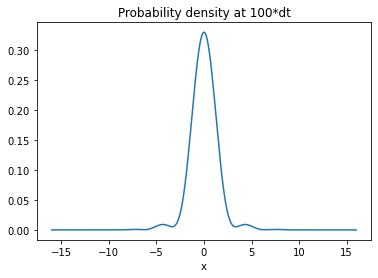

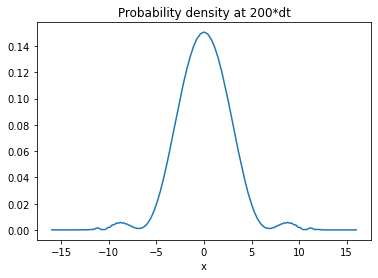

In [14]:
# this stores the Fourier series coefficients for n-m=0 to n-m=2*nmax
def mktrndata():
    # make the potential matrix in the Fourier basis
    vrow = vfbvec[:ntoep] * (-1)**np.arange(ntoep)
    vmat = toeplitz(vrow, vrow.conj())

    # Hamiltonian matrix
    hmat = kmat + vmat
    # check if hmat is Hermitian
    print(nl.norm(hmat - hmat.T.conj()))

    # eigendecomposition
    spec, states = np.linalg.eigh(hmat)

    # check if spec and states diagonalizes hmat
    # if this is close to zero it means that
    # hmat = states @ np.diag(spec) @ np.conj(states).T
    print(nl.norm(hmat @ states - states @ np.diag(spec)))

    # check if we have a unitary matrix
    print(nl.norm(states @ states.conj().T - np.eye(ntoep)))

    propamat = states @ np.diag(np.exp(-1j*spec*dt)) @ np.conj(states.T)

    amat = np.zeros((nt+1, ntoep), dtype=np.complex128)
    amat[0,:] = np.copy(inita)
    for j in range(nt):
        amat[j+1,:] = propamat @ amat[j,:]

    # check if psimattrue is normalized for every time step
    print(np.sqrt(np.sum(np.abs(amat) ** 2, axis=1)))

    return amat

amattru = mktrndata()

plt.plot(xvec, np.abs(amattru[100] @ fbmat)**2)
plt.title('Probability density at 100*dt')
plt.xlabel('x')
plt.show()

plt.plot(xvec, np.abs(amattru[200] @ fbmat)**2)
plt.title('Probability density at 200*dt')
plt.xlabel('x')
plt.show()

In [15]:
# # compute the true propagation from the initial state
# # and the true potential
# _, _, amattru = propa(cfstru, inita, nt, mkgvmat)
#
# # transform amat to real space
# psimattru = amattru @ fbmat
#
# # check if psimattrue is normalized for every time step
# print(np.sqrt(np.sum(np.abs(amattru) ** 2, axis=1)))

<h3>Inverse Problem</h3>

**Code for Adjoint Method**

In [16]:
from IPython.display import clear_output

def mkobjgrdfn(ng, amattruobjgrd, mkgvmatfn):
    # this code computes the objective function give
    # a set of Gaussian basis coefficients as input
    def objfn(cfsobj):
        global glbobjhis, glbitrcnt
        global glbspc, glbstts, glbamat, glblmat

        # propagate initial state with cfsobj
        glbspc, glbstts, glbamat = propa(cfsobj, inita, nt, mkgvmatfn)

        # propagate lambda with glbamat
        glblmat = propl(glbspc, glbstts, glbamat, amattruobjgrd, nt)

        # compute objective
        resid = glbamat - amattruobjgrd
        objct = 0.5*np.real(np.sum(np.conj(resid)*resid))
        glbitrcnt += 1

        # roll the history back one and replace with newest value
        # i.e. put the newest value on the end of the stack
        glbobjhis = np.roll(glbobjhis, -1)
        glbobjhis[-1] = objct

        # print the latest values of the Lagrangian
        # print(f'{glbitrcnt} Objective={glbobjhis[-1]}', end='\x1b[3J')  # \r')
        clear_output()
        print(f'{glbitrcnt} Objective={glbobjhis[-1]}')  #, flush=True)
        return objct

    # compute the gradients
    # the input x is the vector of modeling parameters (theta or thetahat)

    @njit
    def grdhlpfn(spcgrdhlp, sttsgrdhlp):
        dmat = np.zeros((ng, ntoep, ntoep), dtype=np.complex128)
        expspc = np.exp(-1j * dt * spcgrdhlp)
        mask = np.zeros((ntoep, ntoep), dtype=np.complex128)
        for ii in range(ntoep):
            for jj in range(ntoep):
                if np.abs(spcgrdhlp[ii] - spcgrdhlp[jj]) < 1e-8:
                    mask[ii,ii] = expspc[ii]
                else:
                    mask[ii,jj] = (expspc[ii] - expspc[jj])/(-1j * dt * (spcgrdhlp[ii] - spcgrdhlp[jj]))

        for iii in range(ng):
            thisA = sttsgrdhlp.conj().T @ gradgvmat[iii] @ sttsgrdhlp
            qmat = thisA * mask
            dmat[iii,:,:] = -1j * dt * sttsgrdhlp @ qmat @ sttsgrdhlp.conj().T

        return dmat

    def grdfn(_):
        global glbspc, glbstts, glbamat, glblmat, glbdmat

        # compute alldmat
        glbdmat = grdhlpfn(glbspc, glbstts)
        # compute all entries of the gradient at once
        gradients = np.real(np.einsum('ij,ajk,ik->a', np.conj(glblmat[1:, :]), glbdmat, glbamat[:-1, :]))
        return gradients

    return objfn, grdfn

**Check Functions Using True $\theta$**

In [17]:
# check if the Lagrangian of the true theta, xtrue, gives 0

# create objfn and grdfn functions
objectfn, gradfn = mkobjgrdfn(len(xgvec), amattru, mkgvmat)

# set the size of the objective's history
objechistlen = 1
# create the objective's history
glbobjhis = np.zeros(objechistlen)
# initialize variable for counting number of iterations
glbitrcnt = 0


objectfn(cfstru)

1 Objective=0.0822019764672131


0.0822019764672131

In [18]:
# check that the gradient of the Lagrangian is zero for the true theta
gradfn(cfstru)

array([-7.41228788e-07, -4.24577999e-05, -4.20877067e-04, -1.20928696e-03,
       -2.02804597e-03, -3.02791430e-03, -2.83400036e-03, -3.24566943e-03,
       -3.86608342e-03, -4.44518254e-03, -5.42116783e-03, -9.34408221e-03,
       -2.82816563e-02, -1.08669504e-01, -4.35897947e-01, -1.76079492e+00,
       -3.29981241e+00, -1.77425691e+00, -4.42671605e-01, -1.10871987e-01,
       -2.87778721e-02, -9.28144493e-03, -5.19955527e-03, -4.17990368e-03,
       -3.60825619e-03, -3.03690249e-03, -2.67229032e-03, -2.87626426e-03,
       -1.93594919e-03, -1.16096031e-03, -4.04759687e-04, -3.92524127e-05,
       -7.41228788e-07])

---
**Initialize with true coefficents pertubed by random normally distributed noise**

In [19]:
# easy test case: initialize theta with true theta pertubed random normally
# distributed noise with small variance. This should be easy for the optimizer
# to converge to a good minimum

seed = 1234  # set to None for random initialization
cfftrub = cfstru.copy()
# cfftrub += 0.25 * np.random.default_rng(seed).normal(size=cfstru.shape)
cfftrub += 10.0 * np.random.default_rng(seed).normal(size=cfstru.shape)

In [20]:
print(cfftrub.shape)

(33,)


In [21]:
# set the size of the objective's history
objechistlen = 50
# create the objective's history
glbobjhis = np.zeros(objechistlen)
# initialize variable for counting number of iterations
glbitrcnt = 0

restrub = so.minimize(objectfn, cfftrub, jac=gradfn,
                      options={'maxiter': 200, 'disp': True}).x

252 Objective=99.20152496680606
         Current function value: 99.201525
         Iterations: 200
         Function evaluations: 252
         Gradient evaluations: 252


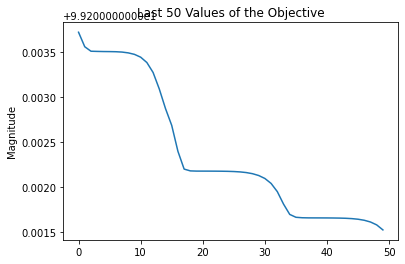

In [22]:
# plot the objective's history
plt.plot(glbobjhis)
plt.title(f'Last {objechistlen} Values of the Objective')
plt.ylabel('Magnitude')
plt.show()

253 Objective=99.20152496680606
Lagrangian for predicted theta:  99.20152496680606
RND predicted theta vs. true theta:  0.4330104365560225
RND predicted v vs. true v:  520.2862283868408
RND predicted v vs. training v:  0.3892398685171395


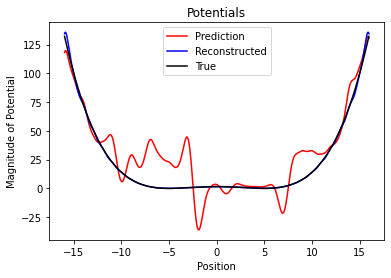

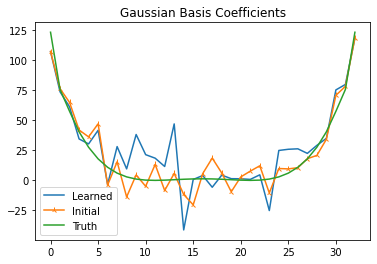

In [23]:
# results

# Print value of objective for predicted theta
print('Lagrangian for predicted theta: ', objectfn(restrub))

# Relative norm difference of predicted theta to true theta
print('RND predicted theta vs. true theta: ', nl.norm(restrub - cfstru) / nl.norm(cfstru))

# use the predicted theta to compute the predicted potential
vtrubprdc = gmatplot @ restrub

# Relative norm difference of the predicted potential to true potential
print('RND predicted v vs. true v: ', nl.norm(vtrue - vtrubprdc))

# Relative norm difference of the predicted potential to training data
print('RND predicted v vs. training v: ', nl.norm(vxtrurec - vtrubprdc) / nl.norm(vxtrurec))

# red = learned potential
# blue = reconstructed potential
# black = true potential
trim = 1
plt.plot(xvec[trim:-trim], vtrubprdc[trim:-trim], color='red', label='Prediction')
plt.plot(xvec[trim:-trim], vxtrurec[trim:-trim], color='blue', label='Reconstructed')
plt.plot(xvec[trim:-trim], vtrue[trim:-trim], color='black', label='True')
plt.title('Potentials')
plt.xlabel('Position')
plt.ylabel('Magnitude of Potential')
plt.legend()
plt.show()

plt.plot(restrub, label='Learned')
plt.plot(cfftrub, '2-', label='Initial')
plt.plot(cfstru, label='Truth')
plt.title('Gaussian Basis Coefficients')
plt.legend()
plt.show()

---
**Initialize theta with uniform random values**

In [176]:
# uniform random values from the interval [-0.5, 0.5]
# this should be difficult for the optimizer to find a good minimum

seed = 1234  # set to None for random initialization
cffform = np.random.default_rng(seed).uniform(low=-0.5, high=0.5, size=cfstru.shape) - 0.5

In [177]:
# set the size of the objective's history
objechistlen = 50
# create the objective's history
glbobjhis = np.zeros(objechistlen)
# initialize variable for counting the number of iterations
glbitrcnt = 0

resform = so.minimize(objectfn, cffform, jac=gradfn, method='BFGS',
                      options={'disp': True, 'maxiter': 100}).x

106 Objective=0.14577010741174412
         Current function value: 0.145770
         Iterations: 100
         Function evaluations: 106
         Gradient evaluations: 106


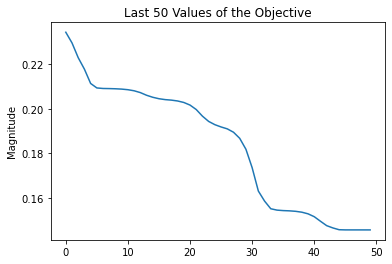

In [178]:
# plot the objective's history
plt.plot(glbobjhis)
plt.title(f'Last {objechistlen} Values of the Objective')
plt.ylabel('Magnitude')
plt.show()

107 Objective=0.14577010741174412
Lagrangian for predicted theta:  0.14577010741174412
RND predicted theta vs. true theta:  1.00178020131155
RND predicted v vs. true v:  1332.4278558499825
RND predicted v vs. training v:  0.9996443777108129
[1.23145610e+02 7.61387105e+01 5.74106044e+01 4.10319355e+01
 2.80645033e+01 1.87638887e+01 4.07972849e+00 7.86484209e-01
 1.94794465e-01 1.58975655e-02 1.87172499e-02 3.03520892e-03
 2.69395269e-03 7.88109448e-03 1.39515931e-02 2.04787706e-02
 2.09978840e-02 2.07055943e-02 1.45014077e-02 7.56570380e-03
 3.22719137e-03 2.62976480e-02 8.34425932e-02 2.27554250e-01
 4.80612957e-01 1.07403409e+00 4.16905078e+00 1.82886354e+01
 2.83925597e+01 4.10419495e+01 5.74753639e+01 7.60935984e+01
 1.23386491e+02]


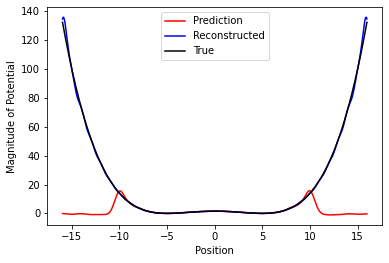

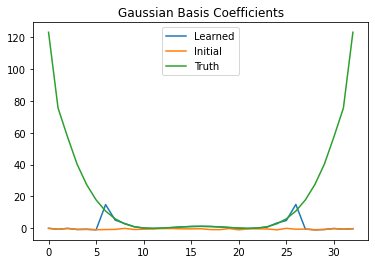

In [179]:
# results

# Print value of objective for predicted theta
print('Lagrangian for predicted theta: ', objectfn(resform))

# Relative norm difference of predicted theta to true theta
print('RND predicted theta vs. true theta: ', nl.norm(resform - cfstru) / nl.norm(cfstru))

# use the predicted theta to compute the predicted potential
vformprdc = gmatplot @ resform

# Relative norm difference of the predicted potential to true potential
print('RND predicted v vs. true v: ', nl.norm(vtrue - vformprdc))

# Relative norm difference of the predicted potential to training data
print('RND predicted v vs. training v: ', nl.norm(vxtrurec - vformprdc) / nl.norm(vxtrurec))

print(np.abs(resform - cfstru))

# red = learned potential
# blue = reconstructed potential
# black = true potential
trim = 1
plt.plot(xvec[trim:-trim], vformprdc[trim:-trim], color='red', label='Prediction')
plt.plot(xvec[trim:-trim], vxtrurec[trim:-trim], color='blue', label='Reconstructed')
plt.plot(xvec[trim:-trim], vtrue[trim:-trim], color='black', label='True')
plt.xlabel('Position')
plt.ylabel('Magnitude of Potential')
plt.legend()
plt.show()

plt.plot(resform, label='Learned')
plt.plot(cffform, '2-', label='Initial')
plt.plot(cfstru, label='Truth')
plt.title('Gaussian Basis Coefficients')
plt.legend()
plt.show()

---

In [35]:
newJ = 32

xgvecnewJ = xgvecfn(bigJ, bigL)

gmatplotnewJ = gbmatfn(xvec, xgvecnewJ, myalpha)

gvmatfnnewJ, gradgvmatnewJ = gvmatgrdvmat(xgvecnewJ, bigL, myalpha)

objfnnewJ, grdfnnewJ = mkobjgrdfn(len(xgvecnewJ), amattru, gvmatfnnewJ)

# generating Gaussian basis matrix for converting oldJ to
# newJ's finner newxg real space grid
gbmatoldtonew = gbmatfn(xgvecnewJ, xgvec, myalpha)

# construct the potential on newJ's real space grid
vxnew = gbmatoldtonew @ resform

# compute Gaussian basis coefficients for newJ
cfsnew = gbcfs(vxnew, xgvecnewJ, myalpha)

In [36]:
# set the size of the objective's history
objechistlen = 50
# create the objective's history
glbobjhis = np.zeros(objechistlen)
# initialize variable for counting the number of iterations
glbitrcnt = 0

resformnew = so.minimize(objfnnewJ, cfsnew, jac=grdfnnewJ, method='BFGS',
                         options={'disp': True, 'maxiter': 100}).x

 Lagrangan=0.1774317923425041420 Lagrangan=0.177422603587244122 Lagrangan=0.1774201472766964724 Lagrangan=0.1774131405141601326 Lagrangan=0.177395747935332828 Lagrangan=0.1773897175720953230 Lagrangan=0.1773886879869044632 Lagrangan=0.177386222999698534 Lagrangan=0.1773791405495060436 Lagrangan=0.177373464210647438 Lagrangan=0.1773723862473849740 Lagrangan=0.1773713598278472442 Lagrangan=0.177368079041914544 Lagrangan=0.1773586757253734546 Lagrangan=0.1773473933360567648 Lagrangan=0.177340024524957450 Lagrangan=0.1773347059760497852 Lagrangan=0.1773305352834999654 Lagrangan=0.177328565662653656 Lagrangan=0.177327475803934658 Lagrangan=0.1773270683056499360 Lagrangan=0.17732586541900562 Lagrangan=0.1773217516467380264 Lagrangan=0.1773084177643655766 Lagrangan=0.177274086962262868 Lagrangan=0.1772311584427970870 Lagrangan=0.1772186434755570772 Lagrangan=0.177217541162029374 Lagrangan=0.177214081721053876 Lagrangan=0.1772024726756576478 Lagrangan=0.177168964972493380 Lagrangan=0.177132206

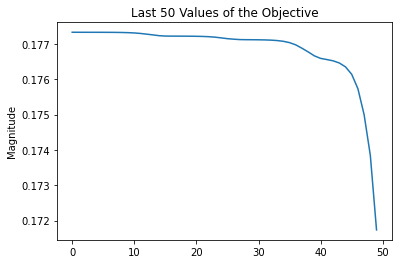

In [37]:
# plot the objective's history
plt.plot(glbobjhis)
plt.title(f'Last {objechistlen} Values of the Objective')
plt.ylabel('Magnitude')
plt.show()

Lagrangian for predicted theta:  0.17173767331772852
RND predicted theta vs. true theta:  1.052018146544605
RND predicted v vs. true v:  1387.6745209824633
RND predicted v vs. training v:  1.0535628736264389


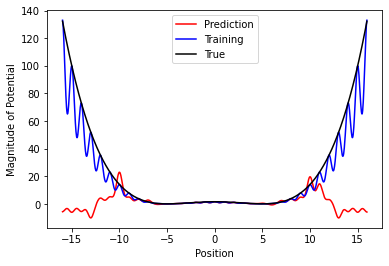

In [38]:
# results

# Print value of objective for predicted theta
print('Lagrangian for predicted theta: ', objectfn(resformnew))

# Relative norm difference of predicted theta to true theta
print('RND predicted theta vs. true theta: ', nl.norm(resformnew - cfstru) / nl.norm(cfstru))

# use the predicted theta to compute the predicted potential
vformprdcnew = gmatplotnewJ @ resformnew

# Relative norm difference of the predicted potential to true potential
print('RND predicted v vs. true v: ', nl.norm(vtrue - vformprdcnew))

# Relative norm difference of the predicted potential to training data
print('RND predicted v vs. training v: ', nl.norm(vxtrurec - vformprdcnew) / nl.norm(vxtrurec))

# red = learned potential
# blue = reconstructed potential
# black = true potential
trim = 1
plt.plot(xvec[trim:-trim], vformprdcnew[trim:-trim], color='red', label='Prediction')
plt.plot(xvec[trim:-trim], vxtrurec[trim:-trim], color='blue', label='Training')
plt.plot(xvec[trim:-trim], vtrue[trim:-trim], color='black', label='True')
plt.xlabel('Position')
plt.ylabel('Magnitude of Potential')
plt.legend()
plt.show()

**Propagate System with Found Coefficents**

Element difference:
 [-0.00015448+0.00502113j  0.00904575+0.00404902j  0.01780947+0.00280006j
 ... -0.01746236+0.00663043j -0.0091857 +0.00584j
 -0.00015448+0.00502113j]
Norm of difference: 1.1453485883162655


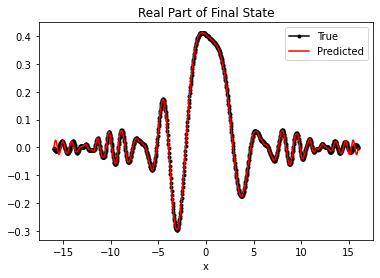

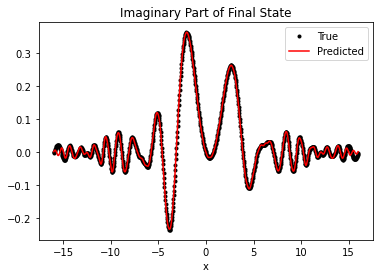

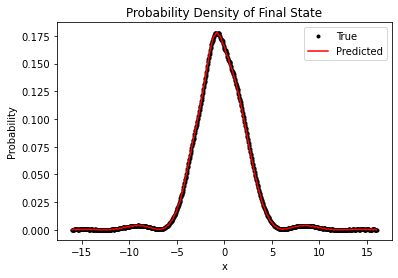

In [30]:
# propagate inita using the predicted coefficients
_, _, amatform, _ = propa(resform.x, inita)
    
# transform amat to real space
psimatform = amatform @ fbmat

print('Element difference:\n', psimatform[-1] - psimattru[-1])
print('Norm of difference:', nl.norm(psimatform - psimattru))

plt.plot(xvec, psimattru[-1].real, 'k.-', label='True')
plt.plot(xvec, psimatform[-1].real, 'r', label='Predicted')
plt.legend()
plt.title('Real Part of Final State')
plt.xlabel('x')
plt.show()

plt.plot(xvec, psimattru[-1].imag, 'k.', label='True')
plt.plot(xvec, psimatform[-1].imag, 'r', label='Predicted')
plt.legend()
plt.title('Imaginary Part of Final State')
plt.xlabel('x')
plt.show()

plt.plot(xvec, np.abs(psimattru[-1]) ** 2, 'k.', label='True')
plt.plot(xvec, np.abs(psimatform[-1])**2, 'r', label='Predicted')
plt.legend()
plt.title('Probability Density of Final State')
plt.xlabel('x')
plt.ylabel('Probability')
plt.show()